In [25]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets 
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable

In [26]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [27]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                     std=(0.5, 0.5, 0.5))])

In [28]:
# MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=True)

In [29]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=100, 
                                          shuffle=True)

In [109]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

In [110]:
D


Sequential (
  (0): Linear (784 -> 256)
  (1): LeakyReLU (0.2)
  (2): Linear (256 -> 256)
  (3): LeakyReLU (0.2)
  (4): Linear (256 -> 1)
  (5): Sigmoid ()
)

In [111]:
# Generator 
G = nn.Sequential(  

    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh())

In [112]:
G

Sequential (
  (0): Linear (64 -> 256)
  (1): LeakyReLU (0.2)
  (2): Linear (256 -> 256)
  (3): LeakyReLU (0.2)
  (4): Linear (256 -> 784)
  (5): Tanh ()
)

In [113]:
if torch.cuda.is_available():
    D.cuda()
    G.cuda()

In [114]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

In [115]:
# Start training
for epoch in range(20):
    for i, (images, _) in enumerate(data_loader):
        # Build mini-batch dataset
        batch_size = images.size(0)
        images = to_var(images.view(batch_size, -1))
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = to_var(torch.ones(batch_size))
        fake_labels = to_var(torch.zeros(batch_size))

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = to_var(torch.randn(batch_size, 64))
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = to_var(torch.randn(batch_size, 64))
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, 200, i+1, 600, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(denorm(images.data), './data/real_images.png')
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), './data/fake_images-%d.png' %(epoch+1))

# Save the trained parameters 
torch.save(G.state_dict(), './generator.pkl')
torch.save(D.state_dict(), './discriminator.pkl')

/home/cs/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/200], Step[300/600], d_loss: 0.2191, g_loss: 5.2262, D(x): 0.95, D(G(z)): 0.13
Epoch [0/200], Step[600/600], d_loss: 0.1543, g_loss: 3.9950, D(x): 0.95, D(G(z)): 0.08
Epoch [1/200], Step[300/600], d_loss: 4.8604, g_loss: 0.9520, D(x): 0.25, D(G(z)): 0.75
Epoch [1/200], Step[600/600], d_loss: 1.8055, g_loss: 1.2955, D(x): 0.44, D(G(z)): 0.33
Epoch [2/200], Step[300/600], d_loss: 0.6069, g_loss: 2.1154, D(x): 0.84, D(G(z)): 0.30
Epoch [2/200], Step[600/600], d_loss: 0.5387, g_loss: 1.6506, D(x): 0.78, D(G(z)): 0.20
Epoch [3/200], Step[300/600], d_loss: 0.8337, g_loss: 1.6816, D(x): 0.69, D(G(z)): 0.28
Epoch [3/200], Step[600/600], d_loss: 0.6997, g_loss: 5.5467, D(x): 0.90, D(G(z)): 0.28
Epoch [4/200], Step[300/600], d_loss: 0.4559, g_loss: 3.3642, D(x): 0.85, D(G(z)): 0.18
Epoch [4/200], Step[600/600], d_loss: 1.1886, g_loss: 2.0739, D(x): 0.61, D(G(z)): 0.25
Epoch [5/200], Step[300/600], d_loss: 1.0453, g_loss: 1.5698, D(x): 0.67, D(G(z)): 0.38
Epoch [5/200], Step[600/600], d_

KeyboardInterrupt: 

In [24]:
# D(images)
batch_size=100
z = to_var(torch.randn(batch_size, nz,1,1))
G(z).size()

NameError: name 'to_var' is not defined

In [212]:
z = to_var(torch.randn(batch_size, 1,22,22))
D(z).size()

torch.Size([100, 1, 1, 1])

In [30]:
nc=1
nz=100
ngf=64
ndf=64

In [33]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [34]:
if torch.cuda.is_available():
    D.cuda()
    G.cuda()
D.apply(weights_init)
G.apply(weights_init)

Sequential (
  (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU (inplace)
  (6): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (8): ReLU (inplace)
  (9): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU (inplace)
  (12): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh ()
)

In [35]:
# Binary cross entropy loss and optimizer
beta1=0.5
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=0.00001, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.00001, betas=(beta1, 0.999))


In [36]:
class Discriminator(nn.Module):
    def __init__(self,nc,ndf):
        super(Discriminator,self).__init__()
        # 32 x 32
        self.layer1 = nn.Sequential(nn.Conv2d(nc,ndf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 16 x 16
        self.layer2 = nn.Sequential(nn.Conv2d(ndf,ndf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 8 x 8
        self.layer3 = nn.Sequential(nn.Conv2d(ndf*2,ndf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 4 x 4
        self.layer4 = nn.Sequential(nn.Conv2d(ndf*4,1,kernel_size=4,stride=1,padding=0),
                                 nn.Sigmoid())

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [37]:
class Generator(nn.Module):
    def __init__(self, nc, ngf, nz):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(nz,ngf*4,kernel_size=4),
                                 nn.BatchNorm2d(ngf*4),
                                 nn.ReLU())
        # 4 x 4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(ngf*4,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.ReLU())
        # 8 x 8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(ngf*2,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.ReLU())
        # 16 x 16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1),
                                 nn.Tanh())

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [48]:
D = Discriminator(nc, ndf).cuda()
G = Generator(nc, ngf, nz).cuda()

In [49]:
# Binary cross entropy loss and optimizer
beta1=0.5
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=0.00001, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.00001, betas=(beta1, 0.999))
z = torch.FloatTensor(batch_size, nz, 1, 1)
z = Variable(z).cuda()

In [55]:
# Start training
for epoch in range(5):
    for i, (images, _) in enumerate(data_loader):
        # Build mini-batch dataset
        batch_size = images.size(0)
        images.view(batch_size, -1)
        images = to_var(images.view(batch_size, 1,32,32))
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = to_var(torch.ones(batch_size))
        fake_labels = to_var(torch.zeros(batch_size))
        
        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        D.zero_grad()
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z.data.resize_(images.size(0), nz, 1, 1)
        z.data.normal_(0,1)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        d_loss_fake.backward()
        # Backprop + Optimize
        
#         D.zero_grad()
        d_loss = d_loss_real + d_loss_fake
      
       
        optimizerD.step()
        
        #=============== Train the generator ===============#
        # Compute loss with fake images
        G.zero_grad()
#         z = to_var(torch.randn(batch_size, nz,1,1))
#         fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop + Optimize
#         D.zero_grad()
        
        g_loss.backward()
        optimizerG.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, 200, i+1, 600, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, images.size(2), images.size(3))
        save_image(denorm(images.data), './data/real_images.png')
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, fake_images.size(2), fake_images.size(3))
    save_image(denorm(fake_images.data), './data/FFFFfake_images-%d.png' %(epoch+1))

# Save the trained parameters 
torch.save(G.state_dict(), './dcgenerator.pkl')
torch.save(D.state_dict(), './dcdiscriminator.pkl')

/home/cs/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/200], Step[300/600], d_loss: 0.4787, g_loss: 1.4048, D(x): 0.85, D(G(z)): 0.26
Epoch [0/200], Step[600/600], d_loss: 0.2817, g_loss: 2.1890, D(x): 0.87, D(G(z)): 0.13
Epoch [1/200], Step[300/600], d_loss: 0.2124, g_loss: 2.4150, D(x): 0.91, D(G(z)): 0.11
Epoch [1/200], Step[600/600], d_loss: 0.1622, g_loss: 2.7221, D(x): 0.93, D(G(z)): 0.09
Epoch [2/200], Step[300/600], d_loss: 0.1296, g_loss: 3.1097, D(x): 0.93, D(G(z)): 0.05
Epoch [2/200], Step[600/600], d_loss: 0.0659, g_loss: 3.5999, D(x): 0.97, D(G(z)): 0.03
Epoch [3/200], Step[300/600], d_loss: 0.0449, g_loss: 4.0774, D(x): 0.98, D(G(z)): 0.02
Epoch [3/200], Step[600/600], d_loss: 0.0396, g_loss: 4.2771, D(x): 0.98, D(G(z)): 0.02
Epoch [4/200], Step[300/600], d_loss: 0.0198, g_loss: 4.8313, D(x): 0.99, D(G(z)): 0.01
Epoch [4/200], Step[600/600], d_loss: 0.0166, g_loss: 5.7256, D(x): 0.99, D(G(z)): 0.00


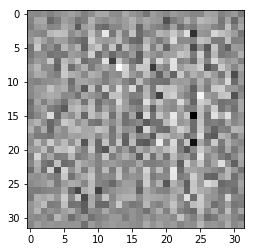

In [341]:
from matplotlib.pyplot import imshow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# imshow(c,cmap='Greys_r')

In [4]:

from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torch.autograd import Variable


In [51]:
# Image processing 
img_size=32
transform = transforms.Compose([transforms.Scale(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                     std=(0.5, 0.5, 0.5))])

In [52]:
# MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=True)

In [53]:
# Data loader
batch_size=100
nc=1
nz=100
ngf=64
ndf=64
niter=10
outf='./'
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=100, 
                                          shuffle=True)

In [13]:
##########   GLOBAL VARIABLES   ###########
noise = torch.FloatTensor(batch_size, nz, 1, 1)
real = torch.FloatTensor(batch_size, nc, img_size, img_size)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

noise = Variable(noise)
real = Variable(real)
label = Variable(label)

noise = noise.cuda()
real = real.cuda()
label = label.cuda()

In [16]:
netD = Discriminator(nc, ndf).cuda()
netG = Generator(nc, ngf, nz=100).cuda()

In [22]:
# Binary cross entropy loss and optimizer
beta1=0.5
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.00001, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.00001, betas=(beta1, 0.999))

In [23]:
########### Training   ###########
for epoch in range(1,niter+1):
    for i, (images,_) in enumerate(data_loader):
        ########### fDx ###########
        netD.zero_grad()
        # train with real data, resize real because last batch may has less than
        # opt.batchSize images
        real.data.resize_(images.size()).copy_(images)
        label.data.resize_(images.size(0)).fill_(real_label)

        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()

        # train with fake data
        label.data.fill_(fake_label)
        noise.data.resize_(images.size(0), nz, 1, 1)
        noise.data.normal_(0,1)

        fake = netG(noise)
        # detach gradients here so that gradients of G won't be updated
        output = netD(fake.detach())
        errD_fake = criterion(output,label)
        errD_fake.backward()

        errD = errD_fake + errD_real
        optimizerD.step()

        ########### fGx ###########
        netG.zero_grad()
        label.data.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        ########### Logging #########
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f '
                  % (epoch, niter, i, len(data_loader),
                     errD.data[0], errG.data[0]))

        ########## Visualize #########
        if(i % 1 == 0):
            vutils.save_image(fake.data,
                        '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                        normalize=True)

torch.save(netG.state_dict(), '%s/netG.pth' % (outf))
torch.save(netD.state_dict(), '%s/netD.pth' % (outf))

/home/cs/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[1/10][0/600] Loss_D: 1.4021 Loss_G: 0.7209 
[1/10][1/600] Loss_D: 1.3885 Loss_G: 0.7217 
[1/10][2/600] Loss_D: 1.3907 Loss_G: 0.7023 
[1/10][3/600] Loss_D: 1.3742 Loss_G: 0.7025 
[1/10][4/600] Loss_D: 1.3365 Loss_G: 0.7266 
[1/10][5/600] Loss_D: 1.3444 Loss_G: 0.7121 
[1/10][6/600] Loss_D: 1.3375 Loss_G: 0.7119 
[1/10][7/600] Loss_D: 1.3018 Loss_G: 0.7134 
[1/10][8/600] Loss_D: 1.3039 Loss_G: 0.7106 
[1/10][9/600] Loss_D: 1.3008 Loss_G: 0.7011 
[1/10][10/600] Loss_D: 1.2674 Loss_G: 0.7195 
[1/10][11/600] Loss_D: 1.2565 Loss_G: 0.7146 
[1/10][12/600] Loss_D: 1.2712 Loss_G: 0.7059 
[1/10][13/600] Loss_D: 1.2356 Loss_G: 0.7220 
[1/10][14/600] Loss_D: 1.2382 Loss_G: 0.7145 
[1/10][15/600] Loss_D: 1.2099 Loss_G: 0.7247 
[1/10][16/600] Loss_D: 1.1878 Loss_G: 0.7390 
[1/10][17/600] Loss_D: 1.1867 Loss_G: 0.7364 
[1/10][18/600] Loss_D: 1.1692 Loss_G: 0.7310 
[1/10][19/600] Loss_D: 1.1638 Loss_G: 0.7242 
[1/10][20/600] Loss_D: 1.1714 Loss_G: 0.7230 
[1/10][21/600] Loss_D: 1.1540 Loss_G: 0.7295

[1/10][177/600] Loss_D: 0.6952 Loss_G: 1.1113 
[1/10][178/600] Loss_D: 0.6861 Loss_G: 1.1175 
[1/10][179/600] Loss_D: 0.7073 Loss_G: 1.1003 
[1/10][180/600] Loss_D: 0.7062 Loss_G: 1.0912 
[1/10][181/600] Loss_D: 0.7056 Loss_G: 1.1114 
[1/10][182/600] Loss_D: 0.7236 Loss_G: 1.1155 
[1/10][183/600] Loss_D: 0.7395 Loss_G: 1.1368 
[1/10][184/600] Loss_D: 0.7333 Loss_G: 1.0944 
[1/10][185/600] Loss_D: 0.6767 Loss_G: 1.1436 
[1/10][186/600] Loss_D: 0.7077 Loss_G: 1.1203 
[1/10][187/600] Loss_D: 0.6903 Loss_G: 1.1295 
[1/10][188/600] Loss_D: 0.6873 Loss_G: 1.1335 
[1/10][189/600] Loss_D: 0.7043 Loss_G: 1.1175 
[1/10][190/600] Loss_D: 0.7071 Loss_G: 1.1145 
[1/10][191/600] Loss_D: 0.6888 Loss_G: 1.1386 
[1/10][192/600] Loss_D: 0.7017 Loss_G: 1.1517 
[1/10][193/600] Loss_D: 0.6769 Loss_G: 1.1447 
[1/10][194/600] Loss_D: 0.6747 Loss_G: 1.1438 
[1/10][195/600] Loss_D: 0.7085 Loss_G: 1.1203 
[1/10][196/600] Loss_D: 0.6775 Loss_G: 1.1357 
[1/10][197/600] Loss_D: 0.6445 Loss_G: 1.1404 
[1/10][198/60

[1/10][352/600] Loss_D: 0.5041 Loss_G: 1.5250 
[1/10][353/600] Loss_D: 0.4950 Loss_G: 1.5051 
[1/10][354/600] Loss_D: 0.4977 Loss_G: 1.5358 
[1/10][355/600] Loss_D: 0.5088 Loss_G: 1.5275 
[1/10][356/600] Loss_D: 0.5369 Loss_G: 1.5215 
[1/10][357/600] Loss_D: 0.4900 Loss_G: 1.5076 
[1/10][358/600] Loss_D: 0.5145 Loss_G: 1.5083 
[1/10][359/600] Loss_D: 0.5179 Loss_G: 1.5101 
[1/10][360/600] Loss_D: 0.5068 Loss_G: 1.5159 
[1/10][361/600] Loss_D: 0.5141 Loss_G: 1.4897 
[1/10][362/600] Loss_D: 0.5072 Loss_G: 1.5213 
[1/10][363/600] Loss_D: 0.5031 Loss_G: 1.5283 
[1/10][364/600] Loss_D: 0.5057 Loss_G: 1.5065 
[1/10][365/600] Loss_D: 0.5099 Loss_G: 1.5288 
[1/10][366/600] Loss_D: 0.5330 Loss_G: 1.5271 
[1/10][367/600] Loss_D: 0.5080 Loss_G: 1.5245 
[1/10][368/600] Loss_D: 0.5402 Loss_G: 1.5144 
[1/10][369/600] Loss_D: 0.4957 Loss_G: 1.5401 
[1/10][370/600] Loss_D: 0.5014 Loss_G: 1.5419 
[1/10][371/600] Loss_D: 0.5218 Loss_G: 1.5769 
[1/10][372/600] Loss_D: 0.5259 Loss_G: 1.5441 
[1/10][373/60

[1/10][527/600] Loss_D: 0.5205 Loss_G: 1.5958 
[1/10][528/600] Loss_D: 0.5289 Loss_G: 1.6068 
[1/10][529/600] Loss_D: 0.5161 Loss_G: 1.6071 
[1/10][530/600] Loss_D: 0.5343 Loss_G: 1.6490 
[1/10][531/600] Loss_D: 0.4924 Loss_G: 1.6410 
[1/10][532/600] Loss_D: 0.5000 Loss_G: 1.6645 
[1/10][533/600] Loss_D: 0.4966 Loss_G: 1.6640 
[1/10][534/600] Loss_D: 0.5185 Loss_G: 1.6399 
[1/10][535/600] Loss_D: 0.4838 Loss_G: 1.6336 
[1/10][536/600] Loss_D: 0.4856 Loss_G: 1.6752 
[1/10][537/600] Loss_D: 0.4676 Loss_G: 1.6816 
[1/10][538/600] Loss_D: 0.5120 Loss_G: 1.7004 
[1/10][539/600] Loss_D: 0.4974 Loss_G: 1.6942 
[1/10][540/600] Loss_D: 0.4962 Loss_G: 1.7057 
[1/10][541/600] Loss_D: 0.5391 Loss_G: 1.6257 
[1/10][542/600] Loss_D: 0.4961 Loss_G: 1.6594 
[1/10][543/600] Loss_D: 0.5111 Loss_G: 1.6919 
[1/10][544/600] Loss_D: 0.5012 Loss_G: 1.7254 
[1/10][545/600] Loss_D: 0.4664 Loss_G: 1.7480 
[1/10][546/600] Loss_D: 0.4371 Loss_G: 1.7307 
[1/10][547/600] Loss_D: 0.4561 Loss_G: 1.7805 
[1/10][548/60

[2/10][104/600] Loss_D: 0.4257 Loss_G: 1.8030 
[2/10][105/600] Loss_D: 0.3965 Loss_G: 1.8558 
[2/10][106/600] Loss_D: 0.3808 Loss_G: 1.8610 
[2/10][107/600] Loss_D: 0.4405 Loss_G: 1.8057 
[2/10][108/600] Loss_D: 0.4010 Loss_G: 1.8355 
[2/10][109/600] Loss_D: 0.4312 Loss_G: 1.8090 
[2/10][110/600] Loss_D: 0.4347 Loss_G: 1.7933 
[2/10][111/600] Loss_D: 0.4024 Loss_G: 1.8093 
[2/10][112/600] Loss_D: 0.4270 Loss_G: 1.7926 
[2/10][113/600] Loss_D: 0.4040 Loss_G: 1.8197 
[2/10][114/600] Loss_D: 0.4015 Loss_G: 1.8113 
[2/10][115/600] Loss_D: 0.3889 Loss_G: 1.8304 
[2/10][116/600] Loss_D: 0.4420 Loss_G: 1.7871 
[2/10][117/600] Loss_D: 0.4342 Loss_G: 1.7901 
[2/10][118/600] Loss_D: 0.4775 Loss_G: 1.7496 
[2/10][119/600] Loss_D: 0.4279 Loss_G: 1.7765 
[2/10][120/600] Loss_D: 0.4252 Loss_G: 1.7581 
[2/10][121/600] Loss_D: 0.4096 Loss_G: 1.7888 
[2/10][122/600] Loss_D: 0.4113 Loss_G: 1.7572 
[2/10][123/600] Loss_D: 0.4812 Loss_G: 1.7383 
[2/10][124/600] Loss_D: 0.4861 Loss_G: 1.7202 
[2/10][125/60

[2/10][279/600] Loss_D: 0.3983 Loss_G: 1.9038 
[2/10][280/600] Loss_D: 0.3864 Loss_G: 1.9083 
[2/10][281/600] Loss_D: 0.3496 Loss_G: 2.0053 
[2/10][282/600] Loss_D: 0.3449 Loss_G: 2.0165 
[2/10][283/600] Loss_D: 0.3681 Loss_G: 2.0126 
[2/10][284/600] Loss_D: 0.3316 Loss_G: 1.9766 
[2/10][285/600] Loss_D: 0.3709 Loss_G: 1.9968 
[2/10][286/600] Loss_D: 0.3422 Loss_G: 2.0144 
[2/10][287/600] Loss_D: 0.3645 Loss_G: 2.0379 
[2/10][288/600] Loss_D: 0.3632 Loss_G: 1.9705 
[2/10][289/600] Loss_D: 0.3247 Loss_G: 1.9989 
[2/10][290/600] Loss_D: 0.3113 Loss_G: 2.0004 
[2/10][291/600] Loss_D: 0.3223 Loss_G: 2.0697 
[2/10][292/600] Loss_D: 0.3449 Loss_G: 2.0218 
[2/10][293/600] Loss_D: 0.3375 Loss_G: 2.0330 
[2/10][294/600] Loss_D: 0.3486 Loss_G: 2.0514 
[2/10][295/600] Loss_D: 0.3402 Loss_G: 1.9794 
[2/10][296/600] Loss_D: 0.3421 Loss_G: 2.0028 
[2/10][297/600] Loss_D: 0.3755 Loss_G: 1.9752 
[2/10][298/600] Loss_D: 0.3454 Loss_G: 2.0342 
[2/10][299/600] Loss_D: 0.3224 Loss_G: 2.0056 
[2/10][300/60

[2/10][456/600] Loss_D: 0.3189 Loss_G: 2.1045 
[2/10][457/600] Loss_D: 0.3073 Loss_G: 2.1989 
[2/10][458/600] Loss_D: 0.3113 Loss_G: 2.0897 
[2/10][459/600] Loss_D: 0.3432 Loss_G: 2.0095 
[2/10][460/600] Loss_D: 0.3058 Loss_G: 2.0339 
[2/10][461/600] Loss_D: 0.2792 Loss_G: 2.1757 
[2/10][462/600] Loss_D: 0.2962 Loss_G: 2.1265 
[2/10][463/600] Loss_D: 0.3227 Loss_G: 2.1636 
[2/10][464/600] Loss_D: 0.2936 Loss_G: 2.1342 
[2/10][465/600] Loss_D: 0.3149 Loss_G: 2.0359 
[2/10][466/600] Loss_D: 0.3094 Loss_G: 2.0900 
[2/10][467/600] Loss_D: 0.3127 Loss_G: 2.1167 
[2/10][468/600] Loss_D: 0.2828 Loss_G: 2.1301 
[2/10][469/600] Loss_D: 0.3052 Loss_G: 2.1728 
[2/10][470/600] Loss_D: 0.2728 Loss_G: 2.2219 
[2/10][471/600] Loss_D: 0.3159 Loss_G: 2.0936 
[2/10][472/600] Loss_D: 0.2915 Loss_G: 2.2187 
[2/10][473/600] Loss_D: 0.2870 Loss_G: 2.1036 
[2/10][474/600] Loss_D: 0.2897 Loss_G: 2.1498 
[2/10][475/600] Loss_D: 0.2774 Loss_G: 2.1652 
[2/10][476/600] Loss_D: 0.2820 Loss_G: 2.1926 
[2/10][477/60

[3/10][33/600] Loss_D: 0.2243 Loss_G: 2.5246 
[3/10][34/600] Loss_D: 0.2256 Loss_G: 2.5248 
[3/10][35/600] Loss_D: 0.2589 Loss_G: 2.3567 
[3/10][36/600] Loss_D: 0.2175 Loss_G: 2.4599 
[3/10][37/600] Loss_D: 0.2096 Loss_G: 2.5114 
[3/10][38/600] Loss_D: 0.2422 Loss_G: 2.4380 
[3/10][39/600] Loss_D: 0.2359 Loss_G: 2.4587 
[3/10][40/600] Loss_D: 0.2078 Loss_G: 2.4850 
[3/10][41/600] Loss_D: 0.2272 Loss_G: 2.4729 
[3/10][42/600] Loss_D: 0.2516 Loss_G: 2.3602 
[3/10][43/600] Loss_D: 0.2542 Loss_G: 2.2623 
[3/10][44/600] Loss_D: 0.2474 Loss_G: 2.2892 
[3/10][45/600] Loss_D: 0.2224 Loss_G: 2.4604 
[3/10][46/600] Loss_D: 0.2256 Loss_G: 2.4626 
[3/10][47/600] Loss_D: 0.2324 Loss_G: 2.4486 
[3/10][48/600] Loss_D: 0.2505 Loss_G: 2.3134 
[3/10][49/600] Loss_D: 0.2343 Loss_G: 2.3498 
[3/10][50/600] Loss_D: 0.2434 Loss_G: 2.3075 
[3/10][51/600] Loss_D: 0.2452 Loss_G: 2.3336 
[3/10][52/600] Loss_D: 0.2385 Loss_G: 2.3888 
[3/10][53/600] Loss_D: 0.2505 Loss_G: 2.2828 
[3/10][54/600] Loss_D: 0.2711 Loss

[3/10][210/600] Loss_D: 0.1969 Loss_G: 2.5393 
[3/10][211/600] Loss_D: 0.1766 Loss_G: 2.6019 
[3/10][212/600] Loss_D: 0.2101 Loss_G: 2.4679 
[3/10][213/600] Loss_D: 0.1920 Loss_G: 2.5545 
[3/10][214/600] Loss_D: 0.1823 Loss_G: 2.6100 
[3/10][215/600] Loss_D: 0.2058 Loss_G: 2.4653 
[3/10][216/600] Loss_D: 0.2087 Loss_G: 2.4960 
[3/10][217/600] Loss_D: 0.1758 Loss_G: 2.6369 
[3/10][218/600] Loss_D: 0.2001 Loss_G: 2.5861 
[3/10][219/600] Loss_D: 0.2099 Loss_G: 2.5633 
[3/10][220/600] Loss_D: 0.1854 Loss_G: 2.5657 
[3/10][221/600] Loss_D: 0.1953 Loss_G: 2.5055 
[3/10][222/600] Loss_D: 0.2181 Loss_G: 2.4188 
[3/10][223/600] Loss_D: 0.1794 Loss_G: 2.5588 
[3/10][224/600] Loss_D: 0.2462 Loss_G: 2.3636 
[3/10][225/600] Loss_D: 0.1794 Loss_G: 2.5533 
[3/10][226/600] Loss_D: 0.2209 Loss_G: 2.4189 
[3/10][227/600] Loss_D: 0.2185 Loss_G: 2.5492 
[3/10][228/600] Loss_D: 0.1724 Loss_G: 2.6864 
[3/10][229/600] Loss_D: 0.2178 Loss_G: 2.4877 
[3/10][230/600] Loss_D: 0.1989 Loss_G: 2.4418 
[3/10][231/60

KeyboardInterrupt: 

In [71]:
z = to_var(torch.randn(batch_size, 1,21,1))

In [349]:
a=fake[22].cpu().data.numpy()

In [350]:
a.shape

(1, 32, 32)

In [326]:
c

array([[[ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.]]], dtype=float32)

In [42]:
z = to_var(torch.randn(batch_size, 64))

In [97]:
test=nn.ConvTranspose2d(     100, ngf*4 ,kernel_size=2, stride=1,padding=0, bias=False).cuda()

In [43]:
G =nn.Sequential(
            # input is (nc) x 64 x 64

            nn.Sigmoid())
G=G.cuda

In [44]:
        z = Variable(torch.randn(1, 1,1,1)).cuda()
    
        

In [45]:
fake_images = G(z)

In [23]:
m = nn.Tanh()

In [24]:
c=m(D(z))

In [62]:
noise = torch.FloatTensor(batch_size, 100, 1, 1)

In [138]:
m = nn.ConvTranspose2d(16, 1, 3, stride=2)

In [139]:
input = Variable(torch.randn(22, 16, 33, 33))


In [140]:
output = m(input)

In [55]:
m = nn.MaxPool1d(5, stride=2)
input = Variable(torch.randn(20, 16, 50))
output = m(input)